# Sentiment Analysis on Amazon Product Reviews

## Part 1. Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
%matplotlib inline 

from time import time
import random
import gensim
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [3]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

### Load Data

In [4]:
# Load csv file
df = pd.read_csv('dataset.csv')
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [5]:
df.describe()

,Price,Rating,Review Votes
count,407907.000000,413840.000000,401544.000000
mean,226.867155,3.819578,1.507237
std,273.006259,1.548216,9.163853
min,1.730000,1.000000,0.000000
25%,79.990000,3.000000,0.000000
50%,144.710000,5.000000,0.000000
75%,269.990000,5.000000,1.000000
max,2598.000000,5.000000,645.000000


In [6]:
df.shape
df['Rating'].size

413840

### Data Visualization 

Text(0, 0.5, 'Count')

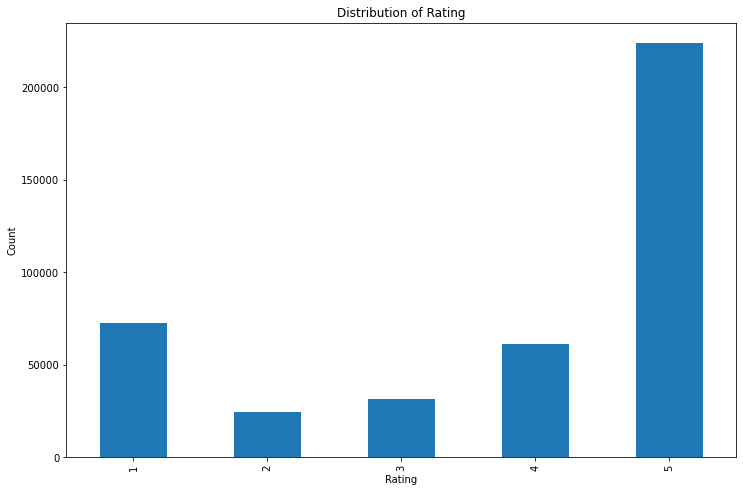

In [7]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

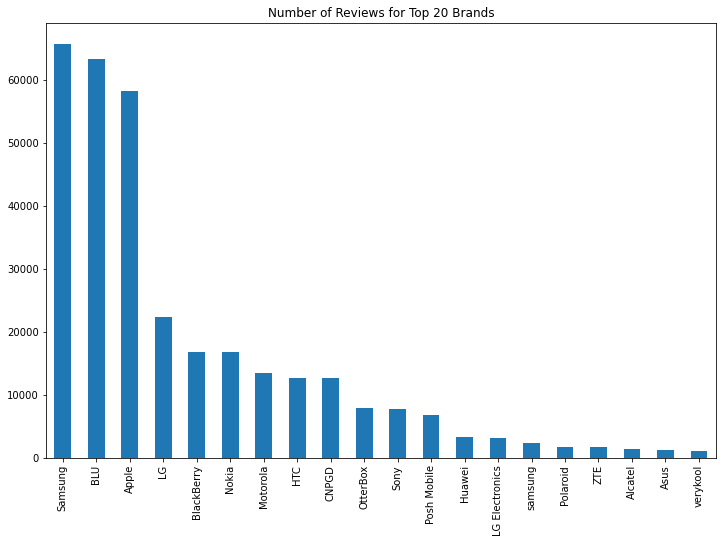

In [8]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

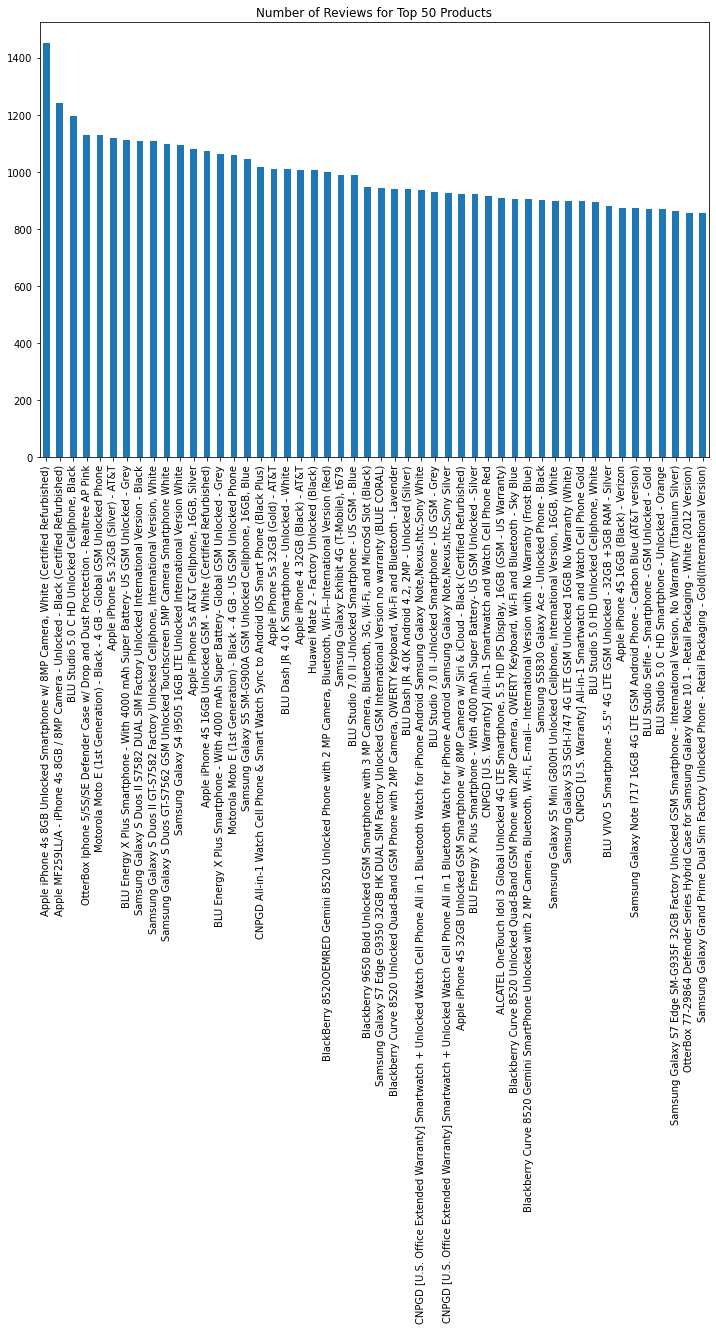

In [9]:
# Plot number of reviews for top 50 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

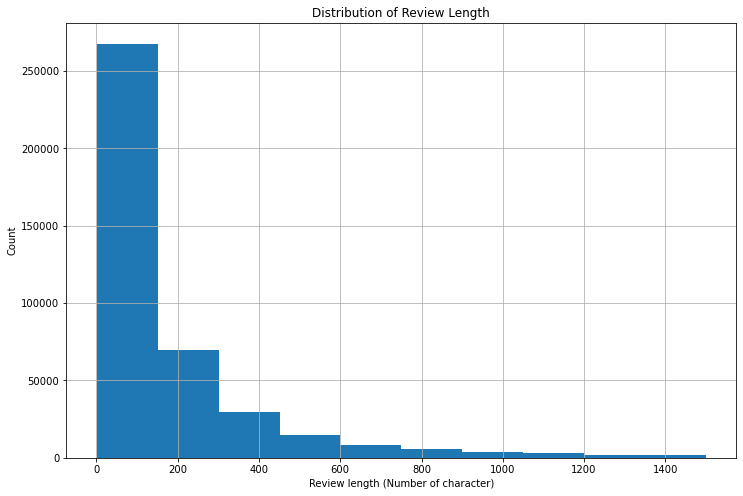

In [10]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [11]:
###Text Preprecessing Refer other ipynb notebook

In [12]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,5,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,5,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,4,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,4,Met expectations! I'm very satisfied!Even arri...,1.0,1


In [13]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Rating"] = df["Rating"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,1,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,1,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,1,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,1,Met expectations! I'm very satisfied!Even arri...,1.0,1
...,...,...,...,...,...,...,...
336011,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,1,excellent,0.0,1
154541,BLU Studio Selfie - Smartphone - GSM Unlocked ...,BLU,2000.00,1,Served its purpose but the camera is terrible!,0.0,0
397667,Sony Xperia Z5 Compact E5823 2GB/32GB 23MP 4.6...,Sony,429.89,1,The best cellphone ever.,0.0,1
88025,BlackBerry Bold 9700 Unlocked GSM 3G World Pho...,BlackBerry,101.99,1,This is an excellent phone for a blackberry. U...,1.0,1


In [14]:
df.shape
df['Rating'].size

30888

In [15]:
#Taking Whole Data
n_samples = 30888
df_sample = df

###Sorting as we want according to time series
df_sample.sort_values('Rating',inplace=True) 
df_sample.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,1,"For the price I paid for this devices, its fan...",0.0,1
265193,Nokia E7-00 Unlocked GSM Phone with Touchscree...,Nokia,49.99,1,"If you are looking for HDMI, a Big Screen, Qwe...",1.0,1
105137,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,1,"Good product, just bought it for third time",0.0,1
216399,LG G2 D802 16GB Factory Unlocked International...,LG,189.99,1,Excellent,0.0,1
235907,LG OPTIMUS L7 P705 Factory Unlocked Internatio...,LG,150.00,1,eres el mejor en este sentido,0.0,1
223355,LG G4 H810 32GB Unlocked GSM 4G LTE Hexa-Core ...,LG,274.95,1,"This was my second attempt to get a G4, and th...",5.0,0
174367,CNPGD All-in-1 Watch Cell Phone & Smart Watch ...,CNPGD,59.99,1,very good product,0.0,1
409683,"verykool s4010 Gazelle 4.0"" TFT LCD Unlocked G...",verykool,50.03,1,Battery life sucks but i LOVE the phone,1.0,0
152388,BLU Studio C Super Camera -Unlocked Smartphone...,BLU,99.00,1,This is slicker than the old Studio 5C HD - wh...,5.0,1
300376,"POSH Titan HD E500a - 5.0"" HD, 4G, Android 4.4...",Posh Mobile,91.91,1,I have had my phone for 10 months now. It work...,0.0,1


In [16]:
#Saving all samples in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_nb")

In [17]:
#Opening from samples from file
df_sample = openfromfile("sample_nb")

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['Reviews'].values,df_sample['Rating'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (21621, 19019)
Test Data Size:  (9267, 19019)


In [19]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(1971, 19019) (1965, 19019)
(3936, 19019) (1965, 19019)
(5901, 19019) (1965, 19019)
(7866, 19019) (1965, 19019)
(9831, 19019) (1965, 19019)
(11796, 19019) (1965, 19019)
(13761, 19019) (1965, 19019)
(15726, 19019) (1965, 19019)
(17691, 19019) (1965, 19019)
(19656, 19019) (1965, 19019)


In [20]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.2 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 1000}
Best Accuracy: 100.00%


### Bernoulli Naive Bayes

In [21]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(alpha=0.001)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


Accuracy on test set: 100.000%
Precision on test set: 1.000
Recall on test set: 1.000
F1-Score on test set: 1.000
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



### Multinomial Naive Bayes

In [22]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.1 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 1000}
Best Accuracy: 100.00%


### Output Visualization

In [23]:
def clean_text(a):
    text=re.sub('[^A-za-z0-9]',' ',a)
    text=text.lower()
    text=text.split(' ')
    text = [wordnet.lemmatize(word) for word in text if word not in (stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [24]:
def predict(a):
  a=clean_text(a)
  x=cov.transform([a])
  if model.predict(x):
    return "Positive"
  else:
    return "Negative"

In [ ]:
ans=predict("I have returned this item 15 days back but no one came to pick up the return order")
print(ans)

Negative